#### iris 데이터셋 활용 꽃잎 너비 예측 모델
- 데이터셋 : iris.csv에서 2개 Feature 사용
- 구현프레임워크 : Pytorch

[1] 모듈 로딩 및 데이터 준비

In [2]:
# 모듈 로딩
import torch                                # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn                       # 인공신경망 관련 모듈
import torch.nn.functional as F             # 손실, 거리 등 함수 관련 모듈
import torch.optim as optimizer             # 최적화 기법 관련 모듈
from torchmetrics.regression import R2Score # 성능지표 관련 모듈 -- 추가 설치
from torchinfo import summary               # 모델 정보 관련 모듈 -- 추가 설치

import pandas as pd                         # 데이터 파일 분석 관련 모듈
from sklearn.model_selection import train_test_split

In [3]:
# 모델의 가중치 및 절편 값 고정 설정
torch.manual_seed(1)

# 저장 및 실행 위치 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'DEVICE => {DEVICE}')

DEVICE => cpu


In [4]:
# 데이터 로딩 : csv => DataFrame
DATA_FILE = '../Data/iris.csv'

irisDF = pd.read_csv(DATA_FILE, usecols=[0, 1, 2, 3])

[2] 모델 준비
- 학습방법 : 지도학습 > 회귀
- 알고리즘 : 선형관계 ==> nnLinear

In [5]:
# 모델 설계
# 입력층에 입력값/피쳐 => sepal.length, sepal.width, petal.length 3개	
# 출력층에 출력값/타겟 => petal.width 1개
# 입력층 : 입력 피쳐3, 출력 입력층에 존재하는 퍼셉트론 개수 10개,   AF(활성함수) - ReLU
#                       |
#               ________|
#              | ReLU
#              V
# 은닉층 : 입력 10개,  출력 입력층에 존재하는 퍼셉트론 개수 5개,     AF - ReLU
#                       |
#               ________|
#              | ReLU
#              V
# 출력층 : 입력 5개    출력 타겟/라벨 개수 1개,                     AF - None
model = nn.Sequential(nn.Linear(3, 10),
                      nn.ReLU(),
                      nn.Linear(10, 5),
                      nn.ReLU(),
                      nn.Linear(5, 1))

In [6]:
# 모델 구조 확인
print(model)
summary(model, input_size=(150, 3))

Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [150, 1]                  --
├─Linear: 1-1                            [150, 10]                 40
├─ReLU: 1-2                              [150, 10]                 --
├─Linear: 1-3                            [150, 5]                  55
├─ReLU: 1-4                              [150, 5]                  --
├─Linear: 1-5                            [150, 1]                  6
Total params: 101
Trainable params: 101
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.02

- 입력층 10개 -> (3+1)*10 = 40
- 은닉층 5개 -> (10+1)*5 = 55
- 출력층 1개 -> (5+1)*1 = 6

In [7]:
# 가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}] {param}\n')

[0.weight] Parameter containing:
tensor([[ 0.2975, -0.2548, -0.1119],
        [ 0.2710, -0.5435,  0.3462],
        [-0.1188,  0.2937,  0.0803],
        [-0.0707,  0.1601,  0.0285],
        [ 0.2109, -0.2250, -0.0421],
        [-0.0520,  0.0837, -0.0023],
        [ 0.5047,  0.1797, -0.2150],
        [-0.3487, -0.0968, -0.2490],
        [-0.1850,  0.0276,  0.3442],
        [ 0.3138, -0.5644,  0.3579]], requires_grad=True)

[0.bias] Parameter containing:
tensor([ 0.1613,  0.5476,  0.3811, -0.5260, -0.5489, -0.2785,  0.5070, -0.0962,
         0.2471, -0.2683], requires_grad=True)

[2.weight] Parameter containing:
tensor([[ 0.3103, -0.1338,  0.2371,  0.0037, -0.1666,  0.1625, -0.1679,  0.0930,
         -0.0913, -0.0347],
        [-0.3040, -0.1508,  0.1716, -0.0769,  0.3150,  0.2535, -0.0148, -0.2111,
          0.1926,  0.0981],
        [-0.2044,  0.2054,  0.1920,  0.2805, -0.1773, -0.0521, -0.0061,  0.0462,
         -0.2400, -0.2244],
        [ 0.1720, -0.0742,  0.1545,  0.0180,  0.1038,  0

[3] 최적화 인스턴스 준비

In [8]:
### 모델의 가중치와 절편을 최적화 ==> 인스턴스에 전달
adam_optim=optimizer.Adam(model.parameters(), lr=0.1)

[4] 학습 ==> 개발자가 구현
- [4-1] 데이터셋 Tensor화 진행 : 데이터준비 시 진행하거나 또는 학습 전 진행

In [9]:
# 피쳐와 타겟 분리
featureDF=irisDF[irisDF.columns[:-1]]
targetDF=irisDF[['petal.width']]

print(featureDF.shape, targetDF.shape)

(150, 3) (150, 1)


In [10]:
# Train & Test
X_train, X_test, y_train, y_test = train_test_split(featureDF,
                                                    targetDF,
                                                    test_size=0.2,
                                                    random_state=5)

# Train & Valid
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=5)

print(f'[feature] X_TRAIN: {X_train.shape}, X_TEST: {X_test.shape}, X_VAL: {X_val.shape}')
print(f'[target] Y_TRAIN:{y_train.shape}, Y_TEST: {y_test.shape}, Y_VAL: {y_val.shape}')

[feature] X_TRAIN: (96, 3), X_TEST: (30, 3), X_VAL: (24, 3)
[target] Y_TRAIN:(96, 1), Y_TEST: (30, 1), Y_VAL: (24, 1)


- [4-2] 학습진행
    * 학습횟수 결정 ==> 에포크 설정
    * 배치크기 결정
    * 배치개수 계산

In [11]:
EPOCH=100                                       # 처음~끝까지 공부하는 횟수
BATCH_SIZE=12                                   # 1 에포크에서 한 번 학습할 분량 크기
BATCH_CNT=X_train.shape[0]//BATCH_SIZE          # 1 에포크에서 총 학습 횟수이면서 업데이트 횟수

print(f'EPOCH: {EPOCH}, BATCH_SIZE: {BATCH_SIZE}, BATCH_CNT: {BATCH_CNT}')

EPOCH: 100, BATCH_SIZE: 12, BATCH_CNT: 8


In [12]:
### 테스트/검증 함수
# ==> 가중치, 절편 업데이트 x, 최적화 미 진행
# ==> 현재 가중치와 절편값으로 테스트 진행

def testing(targetTS, testTS, kind='Val'):
    # Tensor화
    targetTS = torch.FloatTensor(targetTS.values).to(DEVICE)
    testTS = torch.FloatTensor(testTS.values).to(DEVICE)

    with torch.no_grad(): # 가중치 및 절편 업데이트 진행 x
        # (1) 학습 진행 - forward
        pre_y = model(targetTS)
        print(f'{pre_y.shape}')
        
        # (2) 오차 계산 - 손실 함수
        loss=F.mse_loss(pre_y, testTS)

        # (3) 성능평가 - R2
        r2=R2Score()(pre_y, testTS)

        # [선택] 학습결과 출력 및 저장
        print(f'[{kind}] LOSS : {loss}, R2 : {r2}')
    
    return loss, r2

In [13]:
# 모델 학습 함수
def training(featureTS, targetTS, valTS, valTargetTS):
    # [train, val]
    loss_history=[[],[]]
    r2_history=[[],[]]

    for epoch in range(EPOCH):
        
        # 배치 손실 저장 변수
        bs_loss,bs_r2=0,0

        # 배치크기 만큼 학습 진행
        for i in range(BATCH_CNT):
            start = i*BATCH_SIZE
            end = start + BATCH_SIZE
            # print(start, end)

            # - (0) BS크기만큼만 데이터 추출해서 Tensor화 진행
            BSX_train = torch.FloatTensor(X_train[start:end].values).to(DEVICE)
            BSy_train = torch.FloatTensor(y_train[start:end].values).to(DEVICE)
            # print(BSX_train.shape, BSX_train.device, BSX_train.shape)
            # print(BSy_train.shape, BSy_train.device, BSy_train.shape)

            # (1) 학습 진행 - forward
            pre_y = model(BSX_train)
            # print(f'pre_y.shape: {pre_y.shape}')

            # (2) 오차 계산 - 손실 함수
            loss=F.mse_loss(pre_y, BSy_train)
            bs_loss += loss.item()
            bs_r2 += R2Score()(pre_y,BSy_train).item()

            # (3) 최적화 - 가중치, 절편 업데이트 backward
            adam_optim.zero_grad()
            loss.backward()
            adam_optim.step()

        # (4) 검증 - 모델이 제대로 만들어지는 검사용
        val_loss, val_r2 = testing(valTS, valTargetTS)
        loss_history[1].append(val_loss.item())
        r2_history[1].append(val_r2.item())

        # 에포크 단위 손실과 성능지표
        loss_history[0].append(bs_loss/BATCH_CNT)
        r2_history[0].append(bs_r2/BATCH_CNT)

        # [선택] 학습결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}] \n TRAIN LOSS : {loss_history[0][-1]}, R2 : {r2_history[0][-1]}')
        print(f'VAL LOSS : {loss_history[1][-1]}, R2 : {r2_history[1][-1]}')

    return loss_history, r2_history

In [14]:
# 모델 학습 진행
loss, r2 = training(X_train, y_train, X_val, y_val)

torch.Size([24, 1])
[Val] LOSS : 0.4191381633281708, R2 : -0.004299283027648926
[0/100] 
 TRAIN LOSS : 0.9069786705076694, R2 : -0.5297544598579407
VAL LOSS : 0.4191381633281708, R2 : -0.004299283027648926
torch.Size([24, 1])
[Val] LOSS : 0.49096497893333435, R2 : -0.17640399932861328
[1/100] 
 TRAIN LOSS : 0.6465997360646725, R2 : -0.10939279198646545
VAL LOSS : 0.49096497893333435, R2 : -0.17640399932861328
torch.Size([24, 1])
[Val] LOSS : 0.44149693846702576, R2 : -0.05787336826324463
[2/100] 
 TRAIN LOSS : 0.6715940572321415, R2 : -0.1355888992547989
VAL LOSS : 0.44149693846702576, R2 : -0.05787336826324463
torch.Size([24, 1])
[Val] LOSS : 0.3640381097793579, R2 : 0.12772619724273682
[3/100] 
 TRAIN LOSS : 0.6003708094358444, R2 : -0.018216572701931
VAL LOSS : 0.3640381097793579, R2 : 0.12772619724273682
torch.Size([24, 1])
[Val] LOSS : 0.26617205142974854, R2 : 0.36222362518310547
[4/100] 
 TRAIN LOSS : 0.46007593162357807, R2 : 0.2417171597480774
VAL LOSS : 0.26617205142974854, R

In [15]:
loss

[[0.9069786705076694,
  0.6465997360646725,
  0.6715940572321415,
  0.6003708094358444,
  0.46007593162357807,
  0.19732970278710127,
  0.07605496211908758,
  0.1008317454252392,
  0.07504434487782419,
  0.05300577008165419,
  0.04644324001856148,
  0.04479476111009717,
  0.044833490159362555,
  0.04498625104315579,
  0.04434948577545583,
  0.04325701971538365,
  0.042661872459575534,
  0.042554122395813465,
  0.042294645216315985,
  0.041758517269045115,
  0.04132198030129075,
  0.04104750556871295,
  0.04071664530783892,
  0.04036544542759657,
  0.040083488915115595,
  0.039794647600501776,
  0.03951195767149329,
  0.039265384431928396,
  0.03902175556868315,
  0.03880188474431634,
  0.038599199848249555,
  0.038413038244470954,
  0.038248631404712796,
  0.038100275909528136,
  0.037960234796628356,
  0.03752162121236324,
  0.037400985369458795,
  0.03750414028763771,
  0.03719846857711673,
  0.037370461504906416,
  0.037086402997374535,
  0.03735381213482469,
  0.03703165613114834,


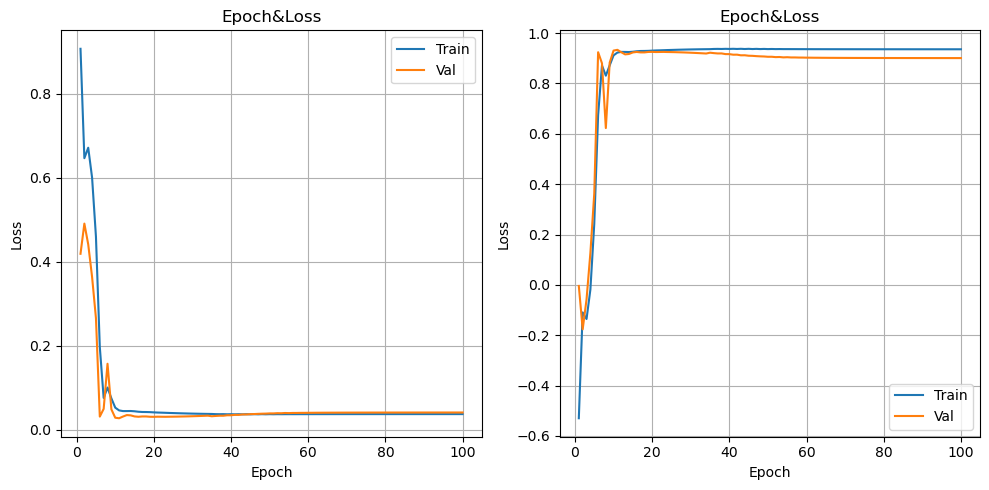

In [16]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

THRESHOLD=100
fg, axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(range(1, THRESHOLD+1), loss[0][:THRESHOLD], label='Train')
axes[0].plot(range(1, THRESHOLD+1), loss[1][:THRESHOLD], label='Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Epoch&Loss')

axes[1].plot(range(1, THRESHOLD+1), r2[0][:THRESHOLD], label='Train')
axes[1].plot(range(1, THRESHOLD+1), r2[1][:THRESHOLD], label='Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Epoch&Loss')
plt.tight_layout()
plt.show()